In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')


wage = pd.read_csv('wage.csv').dropna()
wage['hwage'] = wage["wage"]/wage["hours"]

Efecto de la educación en el salario (logaritmo)

In [2]:
model = smf.ols('np.log(hwage) ~ educ', data=wage).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(hwage)   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     50.61
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           2.94e-12
Time:                        20:10:22   Log-Likelihood:                -384.23
No. Observations:                 663   AIC:                             772.5
Df Residuals:                     661   BIC:                             781.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3071      0.104     22.089      0.0

In [3]:
model = smf.ols('hwage ~ educ', data=wage).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  hwage   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     50.73
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           2.78e-12
Time:                        20:10:22   Log-Likelihood:                -2448.1
No. Observations:                 663   AIC:                             4900.
Df Residuals:                     661   BIC:                             4909.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4811      2.349      2.759      0.0

Utiliza los demás controles

In [4]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

In [5]:
'+'.join(controls)

'IQ+exper+tenure+age+married+black+south+urban+sibs+brthord+meduc+feduc'

In [6]:
model = smf.ols('np.log(hwage) ~ educ + ' + '+'.join(controls), data=wage).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(hwage)   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     13.66
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           4.43e-27
Time:                        20:10:22   Log-Likelihood:                -328.52
No. Observations:                 663   AIC:                             685.0
Df Residuals:                     649   BIC:                             748.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1156      0.232      4.802      0.0



# Teorema de Frisch-Waugh-Lovell

El **Teorema de Frisch-Waugh-Lovell** establece que en una regresión múltiple:

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k + \epsilon
$$

el coeficiente $(\beta_1$) puede obtenerse de manera equivalente en tres pasos:

##  Paso 1: Regresión de $Y$ contra $(X_2, ..., X_k)$
Regresamos $Y$ contra $(X_2, X_3, ..., X_k)$ y obtenemos los residuos $R_Y$:

$$
Y = \gamma_0 + \gamma_2 X_2 + \dots + \gamma_k X_k + R_Y
$$

Donde $R_Y$ representa la parte de $Y$ que *no* está explicada por $X_2, ..., X_k$.

## Paso 2: Regresión de $X_1$ contra $(X_2, ..., X_k)$
Regresamos $X_1$ contra $(X_2, X_3, ..., X_k)$ y obtenemos los residuos $R_{X_1}$:

$$
X_1 = \delta_0 + \delta_2 X_2 + \dots + \delta_k X_k + R_{X_1}
$$

Donde $R_{X_1}$ representa la parte de $X_1$ que no está explicada por $(X_2, ..., X_k)$.

## Paso 3: Regresión de $R_Y$ contra $R_{X_1}$

Finalmente, regresamos $R_Y$ contra $R_{X_1}$:

$$
R_Y = \beta_1 R_{X_1} + \nu
$$

El coeficiente $\beta_1$ obtenido en esta regresión es **idéntico** al de la regresión original:

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k + \epsilon
$$

## Conclusión  
El teorema demuestra que el **efecto de $X_1$ sobre $Y$ ** se puede calcular sin necesidad de incluir todas las variables en una misma regresión, utilizando residuos de regresiones auxiliares.



### Implementando el teorema 

### Parte 1

Predice el salario a partir de todos los controles excepto por la educación

In [7]:
m1 = smf.ols('np.log(hwage) ~' + '+'.join(controls), data=wage).fit()

Obten los residuales, que es la parte del salario que no esta explicada por los controles

In [8]:
# salario sin la educación
residuales_1 = m1.resid

### Parte 2

Predice la educación a partir de los demás controles 

In [9]:
m2 = smf.ols('educ ~' + '+'.join(controls), data=wage).fit()

Obten los residuales, que es la información que está en educación que no puede ser explicada por los controles

In [10]:
residuales_2 = m2.resid
residuales_2

0     -0.351093
2     -0.735607
3     -0.852810
4      0.037336
6     -1.702272
         ...   
924    0.732417
925   -0.864873
928   -0.990416
929    1.234177
931    0.166371
Length: 663, dtype: float64

### Parte 3

Crea un modelo que prediga los residuales del modelo 1 a partir de los residuales del modelo 2

In [11]:
modelo = smf.ols('resid1 ~resid2', data=wage.assign(resid1=residuales_1, resid2=residuales_2)).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                 resid1   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.91
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           4.41e-05
Time:                        20:10:22   Log-Likelihood:                -328.52
No. Observations:                 663   AIC:                             661.0
Df Residuals:                     661   BIC:                             670.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.883e-14      0.015   1.22e-12      1.0

Esto tiene que ser *exactamente igual* que predecir con todos 


¿Por qué esto es importante?

*quiere decir que cuando hacemos una regresión, el coeficiente $\beta_1$ es el efecto de $x_1$ tomando en cuenta toda la información contenida en los demás coeficientes*

¿Por qué esto es importante?

Quiere decir que si hacemos una regresión y usamos todos los controles, podemos aislar el efecto particular de cualquier tratamiento, siempre y cuando se usen los controles pertinentes. 


### Ejemplo de data en el mundo real


Tenemos las ventas de una tienda de helados.

El vendedor de helados quiere cobrar siempre lo más que pueda pero hay una intuición obvia. 

*Si cobro muy caro, nadie va venir*

Contrata a un Data Scientist para que le ayude a entender cuanto cobrar.

Primer paso, regresión lineal

In [12]:
df = pd.read_csv('ice_cream_sales.csv')

In [13]:
df

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227
...,...,...,...,...,...
9995,24.1,5,0.3,5.7,184
9996,26.1,2,0.3,5.3,191
9997,22.0,6,0.3,5.2,171
9998,21.9,1,1.0,7.5,214


Esto suena absurdo, ¿como es posible que a mayor precio, más ventas?

Bivariado de las ventas

pd.qcut(df_calibracion['predicciones'], q=5, labels=False, duplicates='drop')

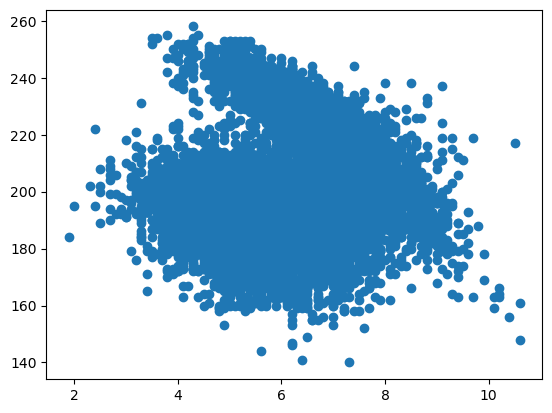

In [14]:
plt.scatter(df['price'], df['sales'])

In [15]:
df.corr()

,temp,weekday,cost,price,sales
temp,1.000000,-0.006214,0.000027,-0.003644,0.375951
weekday,-0.006214,1.000000,0.009161,0.004559,0.011888
cost,0.000027,0.009161,1.000000,0.390435,-0.015494
price,-0.003644,0.004559,0.390435,1.000000,0.075544
sales,0.375951,0.011888,-0.015494,0.075544,1.000000


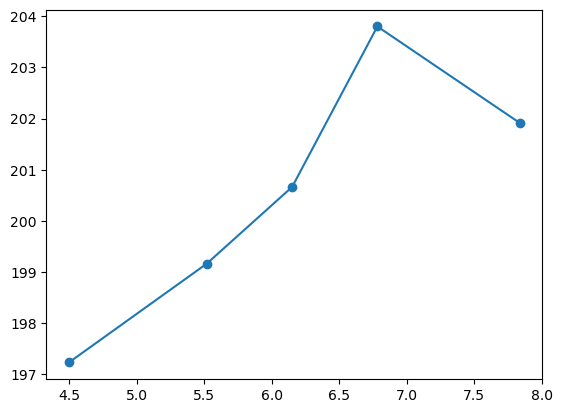

In [16]:
df['bin_price'] = pd.qcut(df['price'], q=5, labels=False, duplicates='drop')
grouped = df.groupby('bin_price').mean()
plt.plot(grouped['price'], grouped['sales'], marker='o');

In [17]:
model = smf.ols('sales ~ price', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     57.38
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           3.90e-14
Time:                        20:10:22   Log-Likelihood:                -43825.
No. Observations:               10000   AIC:                         8.765e+04
Df Residuals:                    9998   BIC:                         8.767e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    192.9679      1.013    190.414      0.0

Efectiamente, según los datos a mayor precio, mayor venta.


Pasa que los vendedores no son tontos, algunos días donde es feriado o que hace mucho calor suben el precio ... y es justamente donde se vende más.

Podemos usar una regrsion linal _controlando por esos factores_.


In [18]:
model = smf.ols('sales ~ price + C(weekday) + temp + cost', data=df).fit()
print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     2315.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:10:22   Log-Likelihood:                -38220.
No. Observations:               10000   AIC:                         7.646e+04
Df Residuals:                    9990   BIC:                         7.653e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         201.9694      1.004    2

Aqui ya podemos ver que el precio tiene un coeficiente negativo, dejando todo lo demás igual si sube el precio las ventas caen 

### Aplicando el teorema de Teorema de Frisch-Waugh-Lovell

In [19]:
m1 = smf.ols('sales ~ C(weekday) + temp + cost', data=df).fit()
m2 = smf.ols('price ~ C(weekday) + temp + cost', data=df).fit()
m3 = smf.ols('sales_resid ~ price_resid', data=df.assign(sales_resid=m1.resid, price_resid=m2.resid)).fit()
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:            sales_resid   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     1327.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          6.29e-273
Time:                        20:10:23   Log-Likelihood:                -38220.
No. Observations:               10000   AIC:                         7.644e+04
Df Residuals:                    9998   BIC:                         7.646e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.843e-13      0.111  -4.38e-12      

### Caso 2

¿Qué tan buena es una medicina?

In [20]:
hospital = pd.read_csv('hospital_treatment.csv')

In [21]:
hospital

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15
...,...,...,...,...
75,1,1,18.879462,41
76,1,1,22.497424,41
77,0,0,2.902651,27
78,1,1,24.634592,39


Regresion días y treatment

In [22]:
model = smf.ols('days ~treatment', data=hospital).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   days   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     17.67
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           6.93e-05
Time:                        20:10:23   Log-Likelihood:                -326.87
No. Observations:                  80   AIC:                             657.7
Df Residuals:                      78   BIC:                             662.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2667      2.662     12.498      0.0

De entrada, parece que la medicina hace que los pacientes duren _más días en el hospital_


Pero ...

En realidad esta medicina se le da a los pacientes que están muy muy mal, aquí hay un sesgo en los datos.

Afortunadamente podemos controlar por severidad

In [23]:
model = smf.ols('days ~treatment + severity', data=hospital).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   days   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     142.9
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           1.20e-26
Time:                        20:10:23   Log-Likelihood:                -273.03
No. Observations:                  80   AIC:                             552.1
Df Residuals:                      77   BIC:                             559.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6641      2.000      5.832      0.0

Ahora la medicina parece que si tiene buen efecto 

Pasa que también depende mucho de los hopspitales, hay hospitales que tienen más pacientes con severidad

In [24]:
# Group by hospital
hospital.groupby('hospital').mean()

,treatment,severity,days
hospital,,,
0,0.068966,7.944987,29.620690
1,0.941176,19.757954,49.215686


Pues hago un modelo que tenga todo, de una vez ... no puede ser malo-

In [25]:
model = smf.ols('days ~treatment + severity + hospital', data=hospital).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   days   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     95.44
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           1.05e-25
Time:                        20:10:23   Log-Likelihood:                -272.56
No. Observations:                  80   AIC:                             553.1
Df Residuals:                      76   BIC:                             562.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0111      2.118      5.198      0.0

El tratamiento tiene un p-value no significativo, ¿qué está pasando?


Recordar la formula del error estadard en una regresión:


$$\sigma^2 = \frac{\Sigma (y_i - \hat{y})^2}{n}$$

$$SE(\beta) = \sqrt{\frac{\sigma^2}{\Sigma (x - E[X])^2}} $$

Si la varianza de X es muy baja, el error estandard será *mayor*


¿Cómo es que la varianza de el tratamiento puede bajar en este caso?

A la hora de aplicar el Teorema de Frisch-Waugh-Lovel el hospital puede predecir la severidad, los residuales serán más pequeños y le predicción del efecto se ve afectada.


In [26]:
m1 = smf.ols('days ~ severity + hospital', data=hospital).fit()
m2 = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
m3 = smf.ols('days_resid ~ treatment_resid', data=hospital.assign(days_resid=m1.resid, treatment_resid=m2.resid)).fit()

print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:             days_resid   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.184
Date:                Thu, 13 Feb 2025   Prob (F-statistic):              0.143
Time:                        20:10:23   Log-Likelihood:                -272.56
No. Observations:                  80   AIC:                             549.1
Df Residuals:                      78   BIC:                             553.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.702e-14      0.827   3.

Si hacemos lo mismo, pero sin hospital el p-value ya es significativo

*Si el objetivo de su regresión está fuertemente ligado a interpretar los coeficientes, no agregar controles que predigan el tratamiento pero no tenga relación real con $y$*

### Un poco más sobre modelado 

Tenemos los datos de tarjeta de crédito de una empresa, queremos predecir cuanto va a gastar un usuario y en función de eso darle un límite de crédito.

Podemos asumir que :

1- A mayor ingreso, mayor gasto

2- A mayor límite de crédito, mayor gasto pero no en la misma proporción


In [29]:
spend = pd.read_csv('spend_data.csv')
spend

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508
...,...,...,...,...,...,...,...,...
49995,840.0,12,13,1,466.0,482.0,2400.0,3441
49996,700.0,15,16,1,328.0,393.0,1100.0,2626
49997,930.0,14,16,1,552.0,339.0,1700.0,3066
49998,1550.0,17,7,1,569.0,536.0,3300.0,4568


In [31]:
spend['wage_bins'] = pd.qcut(spend['wage'], q=5, labels=False) + 1

Grafica el límite de crédito vs gasto, segmentado por salario 

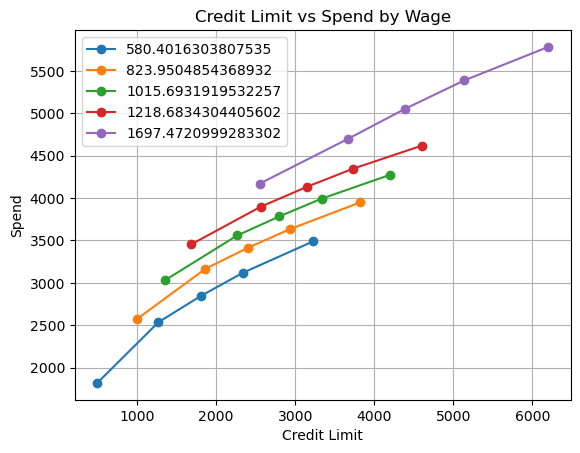

In [33]:
for i in np.sort(spend.wage_bins.unique()):
    flag_df = spend.query('wage_bins == @i')
    flag_df['credit_limit_bin'] = pd.qcut(flag_df['credit_limit'], q=5, labels=False) + 1
    grouped = flag_df.groupby('credit_limit_bin').mean()

    plt.plot(grouped['credit_limit'], grouped['spend'], marker='o', label=np.mean(flag_df['wage']))
plt.legend()
plt.grid()
plt.xlabel('Credit Limit')
plt.ylabel('Spend')
plt.title('Credit Limit vs Spend by Wage');

Efectivamente, líite de crédito, mayor gasto pero no es lineal al segmentar por ingreso.

Predice el gasto usando una regresión simple de salrio y límite de crédito

In [34]:
model = smf.ols('spend ~ wage + credit_limit', data=spend).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  spend   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 4.608e+05
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:30:32   Log-Likelihood:            -3.3935e+05
No. Observations:               50000   AIC:                         6.787e+05
Df Residuals:                   49997   BIC:                         6.787e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1457.4571      2.694    541.036   

### Utilizando una función no lineal vamos a linearizar el modelo

¿Por qué esto mejora?

Bivarido segmentado por el límite de crédito con predicciones 1

Ahora con la segunda prediccion

La predicción 2 se parece más a la realidad